# OFDM Simulation in Pytorch

In [1]:
import torch
import numpy as np

save_plots = True

In [9]:
import matplotlib.pyplot as plt
def visualize_constellation(pts, Qm):
    plt.scatter(pts.numpy().real, pts.numpy().imag)
    plt.title(f'Modulation Order {Qm} Constellation')
    plt.ylabel('Imaginary'); plt.xlabel('Real')
    plt.tight_layout(); 
    if save_plots:
        plt.savefig(f'./const.png')

## Create modulation mapping tables

Modulation mapping tables translate binary data sequences into complex symbols for transmission in digital communication systems. BPSK, QPSK, and 16-QAM, e.g. 64QAM, 256QAM 1024 QAM and so on

In [10]:
def mapping_table(Qm, plot=False):
        
    # Size of the constellation
    size = int(torch.sqrt(torch.tensor(2**Qm)))
    # The constellation
    a = torch.arange(size, dtype=torch.float32)
    # Shift the constellation to the center
    b = a - torch.mean(a)
    # Use broadcasting to create the complex constellation grid
    C = (b.unsqueeze(1) + 1j * b).flatten()
    # Normalize the constellation
    C /= torch.sqrt(torch.mean(torch.abs(C)**2))
    # Function to convert index to binary
    def index_to_binary(i, Qm):
        return tuple(map(int, '{:0{}b}'.format(int(i), Qm)))
    
    # Create the mapping dictionary
    mapping = {index_to_binary(i, Qm): val for i, val in enumerate(C)}
    
    # Create the demapping table
    demapping = {v: k for k, v in mapping.items()}

    if plot:
        visualize_constellation(C, Qm)    
    return mapping, demapping

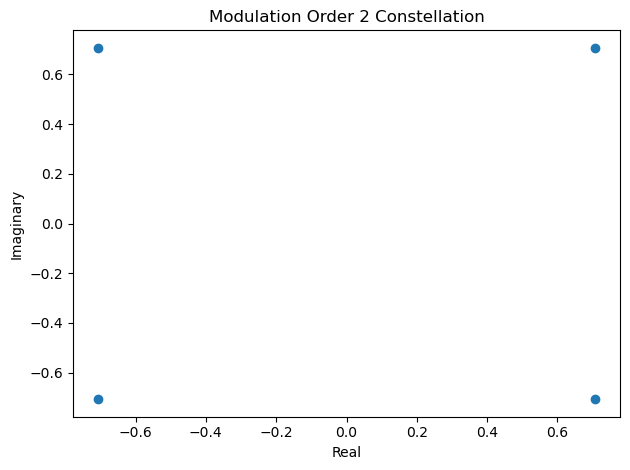

In [11]:
mapping_table_QPSK, de_mapping_table_QPSK = mapping_table(2, plot=True) # mapping table QPSK (e.g. for pilot symbols)

In [6]:
mapping_table_QPSK

{(0, 0): tensor(-0.7071-0.7071j),
 (0, 1): tensor(-0.7071+0.7071j),
 (1, 0): tensor(0.7071-0.7071j),
 (1, 1): tensor(0.7071+0.7071j)}

In [7]:
de_mapping_table_QPSK

{tensor(-0.7071-0.7071j): (0, 0),
 tensor(-0.7071+0.7071j): (0, 1),
 tensor(0.7071-0.7071j): (1, 0),
 tensor(0.7071+0.7071j): (1, 1)}

In [12]:
# OFDM Parameters
#Qm (int): Modulation order
Qm = 6  # bits per symbol

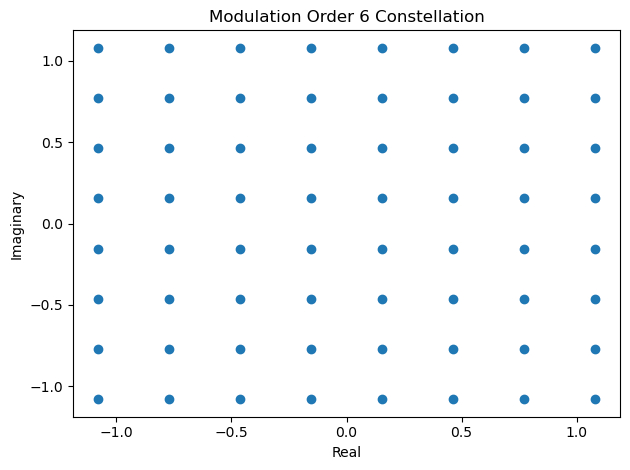

In [13]:
mapping_table_Qm, de_mapping_table_Qm = mapping_table(Qm, plot=True) # mapping table for Qm

In [17]:
mapping_table_Qm

{(0, 0, 0, 0, 0, 0): tensor(-1.0801-1.0801j),
 (0, 0, 0, 0, 0, 1): tensor(-1.0801-0.7715j),
 (0, 0, 0, 0, 1, 0): tensor(-1.0801-0.4629j),
 (0, 0, 0, 0, 1, 1): tensor(-1.0801-0.1543j),
 (0, 0, 0, 1, 0, 0): tensor(-1.0801+0.1543j),
 (0, 0, 0, 1, 0, 1): tensor(-1.0801+0.4629j),
 (0, 0, 0, 1, 1, 0): tensor(-1.0801+0.7715j),
 (0, 0, 0, 1, 1, 1): tensor(-1.0801+1.0801j),
 (0, 0, 1, 0, 0, 0): tensor(-0.7715-1.0801j),
 (0, 0, 1, 0, 0, 1): tensor(-0.7715-0.7715j),
 (0, 0, 1, 0, 1, 0): tensor(-0.7715-0.4629j),
 (0, 0, 1, 0, 1, 1): tensor(-0.7715-0.1543j),
 (0, 0, 1, 1, 0, 0): tensor(-0.7715+0.1543j),
 (0, 0, 1, 1, 0, 1): tensor(-0.7715+0.4629j),
 (0, 0, 1, 1, 1, 0): tensor(-0.7715+0.7715j),
 (0, 0, 1, 1, 1, 1): tensor(-0.7715+1.0801j),
 (0, 1, 0, 0, 0, 0): tensor(-0.4629-1.0801j),
 (0, 1, 0, 0, 0, 1): tensor(-0.4629-0.7715j),
 (0, 1, 0, 0, 1, 0): tensor(-0.4629-0.4629j),
 (0, 1, 0, 0, 1, 1): tensor(-0.4629-0.1543j),
 (0, 1, 0, 1, 0, 0): tensor(-0.4629+0.1543j),
 (0, 1, 0, 1, 0, 1): tensor(-0.462

In [19]:
mapping_table_Qm[(0, 0, 0, 0, 0, 0)]

tensor(-1.0801-1.0801j)

## Creating a TTI Mask with symbol allocations

A TTI mask represents the allocation of the complex symbols over a specific Transmission Time Interval (TTI). It is a matrix or a 2D array where the rows represent the time slots within a TTI, and the columns represent the available symbols in frequency domain. 

In [20]:
# OFDM Parameters
S = 14  # Number of symbols
Sp = 2  # Pilot symbol, 0 for none
F = 72  # Number of subcarriers, including DC
Fp = 2  # Pilot subcarrier spacing
FFT_size = 128  # FFT size

CP = 20  # Cyclic prefix
SCS = 15000  # Subcarrier spacing
P = F // Fp  # Number of pilot subcarriers
FFT_offset = int((FFT_size - F) / 2)  # FFT offset
SampleRate = FFT_size * SCS  # Sample rate
Ts = 1 / (SCS * FFT_size)  # Sample duration
TTI_duration = Ts * (FFT_size + CP) * S * 1000  # TTI duration in ms
Pilot_Power = 1  # Pilot power
PDSCH_power = 1  # PDSCH power

In [28]:
FFT_offset

28

In [21]:
torch.arange(0, F, Fp)#0-70, 2step

tensor([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
        36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70])

In [22]:
# Create a mask with all ones
TTI_mask = torch.ones((S, F), dtype=torch.int8) # all ones (14, 72)

# Set symbol Sp for pilots
TTI_mask[Sp, torch.arange(0, F, Fp)] = 2 # for pilots TX1, #0-70, 2step
# Ensure the first subcarrier is a pilot
TTI_mask[Sp, 0] = 2

# Ensure the last subcarrier is a pilot
TTI_mask[Sp, F - 1] = 2

# DC
TTI_mask[:, F // 2] = 3 # 36 =0 DC to non-allocable power (oscillator phase noise)


In [24]:
TTI_mask.shape

torch.Size([14, 72])

In [25]:
TTI_mask[Sp, :]

tensor([2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
        2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 3, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
        2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2],
       dtype=torch.int8)

In [27]:
TTI_mask[4, :]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=torch.int8)

In [29]:
TTI_1 = torch.zeros(S, FFT_offset, dtype=torch.int8) #(14, 28)
    # Add FFT offsets
TTI_mask = torch.cat((TTI_1, TTI_mask, TTI_1), dim=1)

In [30]:
TTI_mask.shape

torch.Size([14, 128])

In [32]:
#S: number of symbols
#Sp: pilot symbol spacing
#F: number of subcarriers
#Fp: pilot subcarrier spacing (step)
def TTI_mask(S, F, Fp, Sp, FFT_offset, plotTTI=False):

    # Create a mask with all ones
    TTI_mask = torch.ones((S, F), dtype=torch.int8) # all ones (14, 72)

    # Set symbol Sp for pilots
    TTI_mask[Sp, torch.arange(0, F, Fp)] = 2 # for pilots TX1, #0-70, 2step
    # Ensure the first subcarrier is a pilot
    TTI_mask[Sp, 0] = 2

    # Ensure the last subcarrier is a pilot
    TTI_mask[Sp, F - 1] = 2

    # DC
    TTI_mask[:, F // 2] = 3 # DC to non-allocable power (oscillator phase noise)

    TTI_1 = torch.zeros(S, FFT_offset, dtype=torch.int8) #(14, 28)
    # Add FFT offsets
    TTI_mask = torch.cat((TTI_1, TTI_mask, TTI_1), dim=1)

    # Plotting the TTI mask
    if plotTTI:
        plt.figure(figsize=(8, 1.5))
        plt.imshow(TTI_mask.numpy(), aspect='auto')  # Convert tensor to NumPy array for plotting
        plt.title('TTI mask')
        plt.xlabel('Subcarrier index')
        plt.ylabel('Symbol')
        if save_plots:
            plt.savefig('TTImask.png')
        plt.tight_layout()
        plt.show()

    return TTI_mask

0: The PRB is null power.
1: The PRB is PDSCH (Physical Downlink Shared Channel).
2: Pilot symbols
3: (yellow bar) DC

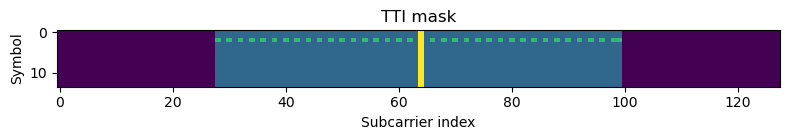

In [33]:
#S=14 symbols, first 28 all zero, last 28 all zero, mid F=72 all 1, Sp=2 (2,1,3), yellow bar =3
TTI_mask_RE = TTI_mask(S=S,F=F, Fp=Fp, Sp=Sp, FFT_offset=FFT_offset, plotTTI=True)

## Creating and Inserting Pilot Symbols in OFDM

Pilot symbols are crucial in OFDM systems for reliable data transmission, aiding in channel estimation, synchronization, and error correction at the receiver. They are predefined, known symbols placed at specific intervals across the OFDM frame. Their known properties help the receiver in demodulating and decoding the received signal accurately.

In [35]:
pilot_values = torch.tensor([-0.7 - 0.7j, -0.7 + 0.7j, 0.7 - 0.7j, 0.7 + 0.7j])

In [37]:
pilot_values.shape

torch.Size([4])

In [42]:
num_pilots = TTI_mask_RE[TTI_mask_RE == 2].numel() 

In [43]:
num_pilots

36

In [44]:
num_pilots//4+1

10

In [54]:
test=pilot_values.repeat(10)[:36] #https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html

In [55]:
test.shape

torch.Size([36])

In [50]:
pilot_values2=pilot_values.repeat(10) #4*10=40
pilot_values2.shape

torch.Size([40])

In [51]:
def pilot_set(TTI_mask, power_scaling=1.0):

    # Define QPSK pilot values, size of 4
    pilot_values = torch.tensor([-0.7 - 0.7j, -0.7 + 0.7j, 0.7 - 0.7j, 0.7 + 0.7j]) * power_scaling

    # Count the number of pilot elements in the TTI mask, Pilot symbols is 2
    num_pilots = TTI_mask[TTI_mask == 2].numel() #36

    # Create a list of pilot values repeated to match the number of pilots
    pilots = pilot_values.repeat(num_pilots//4+1)[:num_pilots] #4 number repeat 10 times=40, select 36 of them

    return pilots


In [34]:
TTI_mask_RE.shape

torch.Size([14, 128])

In [52]:
pilot_symbols = pilot_set(TTI_mask_RE, Pilot_Power)

In [53]:
pilot_symbols.shape

torch.Size([36])

In [57]:
pilot_symbols

tensor([-0.7000-0.7000j, -0.7000+0.7000j,  0.7000-0.7000j,  0.7000+0.7000j,
        -0.7000-0.7000j, -0.7000+0.7000j,  0.7000-0.7000j,  0.7000+0.7000j,
        -0.7000-0.7000j, -0.7000+0.7000j,  0.7000-0.7000j,  0.7000+0.7000j,
        -0.7000-0.7000j, -0.7000+0.7000j,  0.7000-0.7000j,  0.7000+0.7000j,
        -0.7000-0.7000j, -0.7000+0.7000j,  0.7000-0.7000j,  0.7000+0.7000j,
        -0.7000-0.7000j, -0.7000+0.7000j,  0.7000-0.7000j,  0.7000+0.7000j,
        -0.7000-0.7000j, -0.7000+0.7000j,  0.7000-0.7000j,  0.7000+0.7000j,
        -0.7000-0.7000j, -0.7000+0.7000j,  0.7000-0.7000j,  0.7000+0.7000j,
        -0.7000-0.7000j, -0.7000+0.7000j,  0.7000-0.7000j,  0.7000+0.7000j])

## Data stream creation OFDM Modulation, FFT, and Cyclic Prefix Addition

In [60]:
len(mapping_table_Qm)

64

In [62]:
TTI_mask_RE.shape

torch.Size([14, 128])

In [64]:
TTI_mask_RE.eq(1).sum()

tensor(958)

In [ ]:
#TTI_mask: [14, 128]
#Qm = 6  # bits per symbol
#mapping_table_Qm  64 len dict
def create_PDSCH_data(TTI_mask, Qm, mapping_table, power=1.):
    # Count PDSCH elements =1
    pdsch_elems = TTI_mask.eq(1).sum() #958
    
    # Generate random bits
    bits = torch.randint(0, 2, (pdsch_elems, Qm), dtype=torch.float32)

    # Flatten and reshape bits for symbol lookup
    flattened_bits = bits.reshape(-1, Qm)
   
    # Convert bits to tuples and lookup symbols
    symbs_list = [mapping_table[tuple(row.tolist())] for row in flattened_bits]
    symbs = torch.tensor(symbs_list, dtype=torch.complex64)

    # Reshape symbols back to original shape
    symbs = symbs.view(pdsch_elems, -1)
    symbs = symbs.flatten()
    
    # Apply power scaling 
    symbs *= power
    
    return bits, symbs

In [ ]:
pdsch_bits, pdsch_symbols = create_PDSCH_data(TTI_mask_RE, Qm, mapping_table_Qm, power=PDSCH_power) # create PDSCH da